In [1]:
#Import the libraries
import numpy as np
import pandas as pd

import pickle

import warnings
warnings.filterwarnings("ignore")

## SARIMAX

In [2]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

### Training BKK with *minimal_SARIMAX*

In [3]:
import sys
sys.path.append('../')

In [4]:
from importlib import reload

from custom_function import minimalSARIMAX

reload(minimalSARIMAX)

from custom_function.minimalSARIMAX import MinimalSARIMAX

In [5]:
train_set = pd.read_csv('6Hsampled_data_set/SARA/train_set.csv')
train_set['WindDirSin'] = np.sin(train_set['WindDir'])*10 + 10
train_set['WindDirCos'] = np.cos(train_set['WindDir'])*10 + 10 
train_set['Time'] = pd.to_datetime(train_set['Time'])
train_set = train_set.set_index('Time')

valid_set = pd.read_csv('6Hsampled_data_set/SARA/valid_set.csv')
valid_set['WindDirSin'] = np.sin(valid_set['WindDir'])*10 + 10 
valid_set['WindDirCos'] = np.cos(valid_set['WindDir'])*10 + 10 
valid_set['Time'] = pd.to_datetime(valid_set['Time'])
valid_set = valid_set.set_index('Time')

test_set = pd.read_csv('6Hsampled_data_set/SARA/test_set.csv')
test_set['WindDirSin'] = np.sin(test_set['WindDir'])*10 + 10 
test_set['WindDirCos'] = np.cos(test_set['WindDir'])*10 + 10 
test_set['Time'] = pd.to_datetime(test_set['Time'])
test_set = test_set.set_index('Time')

##### Tuning Parameters

In [6]:
order = (1, 0, 2)
seasonal_order = (1, 0, 1, 1461)

exog_order = {}
exog_order['Temp'] = (2, 1, 2)
exog_order['WindSpeed'] = (1, 1, 1)
exog_order['WindDirSin'] = (1, 1, 1)
exog_order['WindDirCos'] = (2, 0, 2)

exog_seasonal_order = {}
exog_seasonal_order['Temp'] = (1, 0, 1, 1461)
exog_seasonal_order['WindSpeed'] = (1, 0, 0, 1461)
exog_seasonal_order['WindDirSin'] = (1, 1, 0, 1461)
exog_seasonal_order['WindDirCos'] = (1, 1, 1, 1461)

exog_columns = ['Temp', 'WindSpeed', 'WindDirSin', 'WindDirCos']

In [7]:
model = {}
model_exog = {}

model = MinimalSARIMAX(train_set[['PM25']],
                          order,
                          seasonal_order,
                          exog=train_set[exog_columns])
    
model_exog = {}
for exog in exog_columns:
    model_exog[exog] = MinimalSARIMAX(train_set[[exog]],
                                      exog_order[exog],
                                      exog_seasonal_order[exog])

In [8]:
model.fit(lr=1e-6, lr_decay=0.999 ,verbose=0)

for exog in exog_columns:
        model_exog[exog].fit(lr=1e-6, lr_decay=0.999, verbose=0)
        _ = model_exog[exog].predict_step(train_set[[exog]],
                                          valid_set[[exog]], 
                                          lr=np.array([1e-6]), lr_decay=0.9995, lr_decay_iter=0.75,
                                          step=12, n_iter=1, learn=True, verbose=1)

100%|██████████| 4383/4383 [07:15<00:00, 10.07it/s]


ITER#0  RMSE:5.306957432789971


100%|██████████| 4383/4383 [07:12<00:00, 10.13it/s]


ITER#0  RMSE:16.67154185707643


100%|██████████| 4383/4383 [07:26<00:00,  9.82it/s]


ITER#0  RMSE:10.139193328899786


100%|██████████| 4383/4383 [07:37<00:00,  9.58it/s]

ITER#0  RMSE:9.539992021793225


#### Saraburi

In [9]:
Result_train = model.predict_step(train_set[['PM25']],
                                  valid_set[['PM25']], 
                                  val_X_exog=train_set[exog_columns],
                                  y_exog=valid_set[exog_columns], 
                                  model_exog=model_exog,
                                  lr=np.array([1e-6, 1e-6, 1e-6, 5e-7]), lr_decay=0.99875, lr_decay_iter=10,
                                  step=12, n_iter=3, learn=True, verbose=1)

train_pred_sav, val1_pred_sav, Error_save = Result_train

100%|██████████| 4383/4383 [25:25<00:00,  2.87it/s]


ITER#0  RMSE:20.79660048027864


100%|██████████| 4383/4383 [23:44<00:00,  3.08it/s]


ITER#1  RMSE:19.565039885507215


100%|██████████| 4383/4383 [23:49<00:00,  3.07it/s]

ITER#2  RMSE:18.86462082199187


In [10]:
train_pred_sav

,Time,Predict,Actual
0,2017-07-01 00:00:00,10,21.666667
1,2017-07-01 06:00:00,31.057181,19.833333
2,2017-07-01 12:00:00,35.244415,18.333333
3,2017-07-01 18:00:00,37.298631,28.833333
4,2017-07-02 00:00:00,36.672607,37.000000
...,...,...,...
36734,2019-08-06 12:00:00,17.867496,9.333333
36735,2019-08-06 18:00:00,17.333714,12.500000
36736,2019-08-06 12:00:00,17.653908,9.333333
36737,2019-08-06 18:00:00,17.233455,12.500000


In [11]:
with open('../model_save/model_sara.model',"wb") as f:
    pickle.dump(model, f)

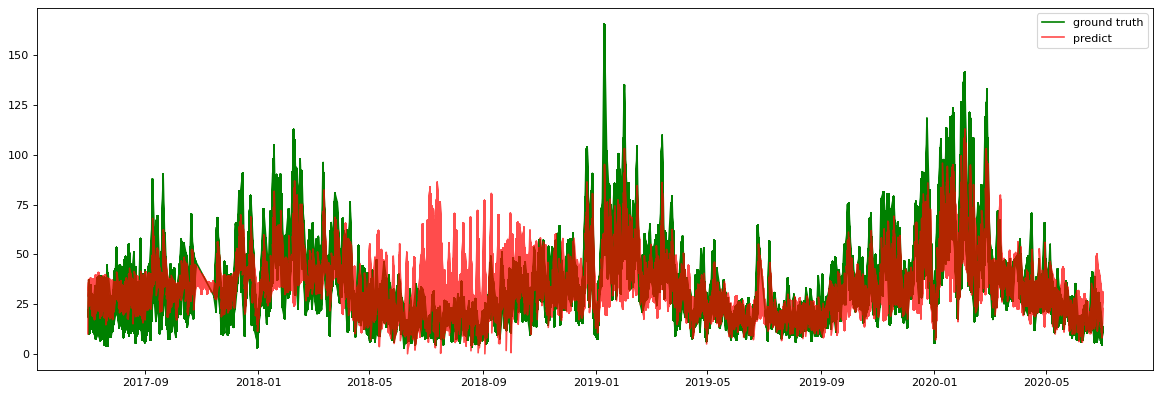

In [12]:
train_X = pd.concat([train_pred_sav, val1_pred_sav])
train_X = train_X.set_index('Time')

plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_X['Actual'], color='g', label='ground truth')
plt.plot(train_X['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [13]:
Result_test = model.predict_step(valid_set[['PM25']],
                                               test_set[['PM25']], 
                                               val_X_exog=valid_set[exog_columns],
                                               y_exog=test_set[exog_columns], 
                                               model_exog=model_exog,
                                               lr=np.array([1e-7, 1e-7, 1e-7, 5e-9]), lr_decay=0.9998975,
                                               step=12, n_iter=1, learn=False)	

val2_pred_sav, test_pred_sav, Error_save = Result_test

ITER#0  RMSE:18.16974028266845


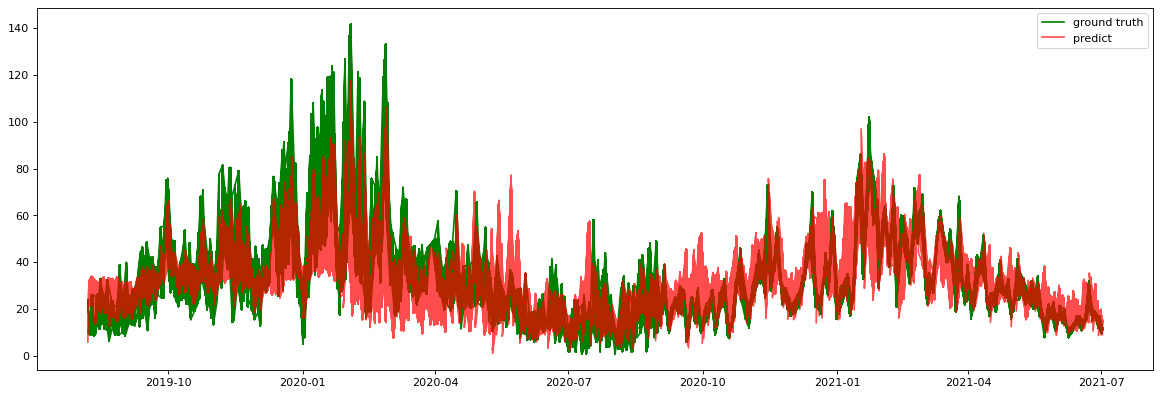

In [14]:
test_X = pd.concat([val2_pred_sav, test_pred_sav])
test_X = test_X.set_index('Time')

plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test_X['Actual'], color='g', label='ground truth')
plt.plot(test_X['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [15]:
((Error_save**2).mean())**(1/2)

18.16974028266845

In [16]:
test_pred_sav.to_csv('../answer_dataset/pred_and_actual/y_pred_sav_SARA.csv')